FIDE Chess Machine Learning
---

Frame the Problem and Look at the Big Picture
---

**1. Define the objective in business terms.**

The objective of this problem is to discover interesting trends in the world of competitive chess. FIDE will be focused on rather than national chess organizations because they have the toughest competition. FIDE is where who will be the next world champion is decided. We want to predict who the next world chess champion is going to be. We also want to figure out what the record for the highest ELO is going to be (whether it will break the current ceiling or not). We want to find out what chess players are trending in a good direction for breaking the current ceiling (setting a record) and becoming world champion. We also want to find out what countries will generate the next best players.

**2. How will your solution be used?**

Our solution can be used for a variety of ways from determining specific statistics and trends about current players to studying how players become better at chess overtime depending on age, gender and country of origin. Our dataset can be used by worldwide chess federations to determine how to grow and get better players.

**3. What are the current solutions/workarounds (if any)?**

There are no currently existing solutions. There are however machine learning solutions for a computer to play chess. These solutions are highly effective and computers are extremely strong at chess. This could possibly help us if we applied this to analyzing games of different players to find trends.

**4. How should you frame this problem (supervised/unsupervised, online/offline, ...)?**

This is a supervised regression problem because we are using historical data to predict a continuous feature. The system should be offline as the data is only updated around every year. This could also be done as a classification problem because we are trying to figure out if someone will be world champion or not. However, the world champion is most likely just going to be the person with the highest rating. But this does not necessarily always need to be true, especially in the future. This part might be able to be classification if we create a second model that we feed the results of the first model (the one that predicts ELO) into.

**5. How should performance be measured? Is the performance measure aligned with the business objective?**

Performance on the predicted ELO can be measured by measuring the mean square error of the predictions. Because this is a forecasting problem, we would take a window of our data instead of a test set. For the classification part, the performance can be measured by taking the accuracy of the predictions. The performance will definitely be aligned with our business objective since we want to accurately predict future ELO and accurately predict future world chess champions.

**6. What would be the minimum performance needed to reach the business objective?**

The minimum performance needed to reach the business objective could be subjected to the idea that we want our solution to be very accurate in at least placing players within a range of 10-20 rank for where they will be placed for coming years. If we can achieve accuracy where we can label what countries have the most prolific chess players and label what countries are achieving the most growth that would be a good place to start with the idea of minimum performance.

**7. What are comparable problems? Can you reuse experience or tools?**

When jumping into this problem the first thing that came to my mind in terms of comparable problems was the housing income problem where we ultimately tried to discover interesting remarks about the housing income and prices in a specified area. Taking this into account we can look at how that problem can be somewhat comparable as we are taking individuals (houses) from specific countries (locations) and seeing what their value / skill is to the game of chess (price). Weather forecasting is also somewhat similar.

**8. Is human expertise available?**
Chess is a very popular hobby / sport in which millions of people take part in. There are tons of very good developers that have made projects similar to ours so that may be of use to us. There is human expertise in the form of chess grandmasters and commentators. They understand the players as people and they understand their playing styles. They can predict rank/world champion based on this criteria.

**9. How would you solve the problem manually?**

The problem could be solved manually by first finding out whether someone has peaked or not. If someone has peaked then they can be ruled out for increasing ELO or becoming world chess champion. Most younger players definitely have not peaked. This is the group that is the most interesting and promising for future world champions. We could find the fastest growing younger players and simply choose one of them as a candidate for future world championships.

**10. List the assumptions you (or others) have made so far. Verify assumptions if possible.**

The assumptions that we have made so far would include that all of the data provided is accurate and updated correctly. This includes players’ age, gender, ELO rating, country of origin and title.


In [1]:
import ast

import numpy as np
import scipy.sparse
import scipy as sp
import pandas as pd

import matplotlib.pylab as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer

Get the Data
---
**1. List the data you need and how much you need**

For our problem we will need a whole set of data about all types of demographics, ratings, and names of all players that are listed and rated under FIDE... On top of that it would be beneficial to have multiple years included with all of this data alongside it.

**2. Find and document where you can get that data** 

We will most likely end up using data that is compiled on a website called kaggle. The link is posted below.

https://www.kaggle.com/datasets/rohanrao/chess-fide-ratings?select=players.csv

**3. Get access authorizations** 

Kaggle datasets are publically avaliable

**4. Create a workspace (with enough storage space)** 

VSCode Jupyter Notebooks

**5. Get the data** 

Done

**6. Convert the data to a format you can easily manipulate (without changing the data itself)** 

Currently in csv format which is easily usable

**7. Ensure sensitive information is deleted or protected (e.g. anonymized)** 

Done

**8. Check the size and type of data (time series, geographical, ...)** 

around 200.5 MbS..

**9. Sample a test set, put it aside, and never look at it (no data snooping!)** 

Explore the Data 
---

In [2]:
def load_players_data():
    """
    Loads the CSV file which contains our data for players.
    """
    return pd.read_csv('players.csv')

def load_ratings(year):
    """
    These functions load each individuals years data,
    """
    return pd.read_csv('ratings_' + str(year) + '.csv')

**1. Copy the data for exploration, downsampling to a manageable size if necessary.**

In [3]:
players = load_players_data()
year_15 = load_ratings(2015)
year_16 = load_ratings(2016)
year_17 = load_ratings(2017)
year_18 = load_ratings(2018)
year_19 = load_ratings(2019)
year_20 = load_ratings(2020)
year_21 = load_ratings(2021)

In [4]:
players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433388 entries, 0 to 433387
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   fide_id     433388 non-null  int64 
 1   name        433388 non-null  object
 2   federation  433388 non-null  object
 3   gender      433388 non-null  object
 4   title       19498 non-null   object
 5   yob         433388 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 19.8+ MB


In [5]:
players.describe()

,fide_id,yob
count,4.333880e+05,433388.000000
mean,1.979331e+07,1940.034408
std,5.138192e+07,290.260909
min,1.000130e+05,0.000000
25%,2.510166e+06,1966.000000
50%,1.232708e+07,1986.000000
75%,2.500971e+07,2001.000000
max,6.510818e+08,2015.000000


In [6]:
players.head(20)

,fide_id,name,federation,gender,title,yob
0,100013,"Campora, Daniel H.",ARG,M,GM,1957
1,100021,"Quinteros, Miguel A.",ARG,M,GM,1947
2,100048,"Iapichello, Javier",ARG,M,NaN,1990
3,100064,"Schipper, Bernardo",ARG,M,NaN,2000
4,100072,"Adla, Diego",ARG,M,IM,1968
5,100080,"Bianchi, Guillermo",ARG,M,IM,1958
6,100102,"Cid, Marino Alejandro",ARG,M,IM,1958
7,100110,"Sanchez Almeyra, Jorge",ARG,M,IM,1968
8,100129,"Gomez Baillo, Jorge H.",ARG,M,IM,1959
9,100137,"Zarnicki, Pablo",ARG,M,GM,1972


In [7]:
title_values = players['title'].value_counts().reset_index()
title_values

,index,title
0,FM,8245
1,IM,3887
2,CM,1898
3,WFM,1758
4,GM,1727
5,WIM,837
6,WCM,781
7,WGM,318
8,NI,23
9,DI,17


In [8]:
year_15.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2680191 entries, 0 to 2680190
Data columns (total 6 columns):
 #   Column           Dtype  
---  ------           -----  
 0   fide_id          int64  
 1   year             int64  
 2   month            int64  
 3   rating_standard  float64
 4   rating_rapid     float64
 5   rating_blitz     float64
dtypes: float64(3), int64(3)
memory usage: 122.7 MB


In [9]:
year_15.describe()

,fide_id,year,month,rating_standard,rating_rapid,rating_blitz
count,2.680191e+06,2680191.0,2.680191e+06,2.554932e+06,621048.000000,506504.000000
mean,1.118616e+07,2015.0,6.676958e+00,1.828016e+03,1828.961328,1866.914099
std,1.291850e+07,0.0,3.449523e+00,3.034101e+02,310.426087,303.837760
min,1.000130e+05,2015.0,1.000000e+00,1.001000e+03,1000.000000,1000.000000
25%,1.515837e+06,2015.0,4.000000e+00,1.627000e+03,1620.000000,1666.000000
50%,4.655672e+06,2015.0,7.000000e+00,1.856000e+03,1841.000000,1881.000000
75%,1.990007e+07,2015.0,1.000000e+01,2.053000e+03,2044.000000,2074.000000
max,3.832667e+08,2015.0,1.200000e+01,2.876000e+03,2873.000000,2948.000000


**2. Study each attribute and its characteristics: Name; Type (categorical, numerical, bounded, text, structured, ...); % of missing values; Noisiness and type of noise (stochastic, outliers, rounding errors, ...); Usefulness for the task; Type of distribution (Gaussian, uniform, logarithmic, ...)** 

Players
---
The 'fide_id' column is a categorical attribute. It is a unique integer that represents a players id. This is a useful attribute for identifying the different players. No missing values. No noisiness due to it being a set integer. Might as well be a string.

The 'name' column is a text attribute that has the player's name. We already have 'fide_id' which will categorize players so not all that useful. No missing values. No noisiness and no type of distribtion due to it being a str

The 'federation' column is a categorical text attribute. It has the federation the player is a part of. Could be intresting to see distribution amongst nations not that useful though for direct task on hand. If missing value it's filled with 'NaN' this is because some players don't belong to a federation. No noisiness and no type of distribtion due to it being a str

The 'gender' column is a categorical text attribute. It has the gender of the player. Again could be useful in study of Men vs Women for fun analysis but not useful for task at hand. Slight amount of missing values will have to fill that in with NaN's. No noisiness and the distribution is not needed.

The 'title' column is a categorical text attribute. It has the title of the player. It is NaN if the player is untitled. Could be useful in sense that we could find top players by already having sense of skill but in terms of predicting future ELO it's not all that important. Certain ranks will reflect how easily or difficult it is to progress further. No missing values. No noisiness and the distribution most closely resembles a log

The 'yob' column is a numerical integer column. It has the year the player was born. This feature is not useful at all. Most likely will drop this column. Several Missing values will fill in with NaN's No noisiness and no type of distribution due to it being a str.

Ratings
---
The 'fide_id' column is a categorical attribute. It is a unique integer that represents a players id. This is a useful attribute for identifying the different players. No missing values. No noisiness due to it being a set integer. Might as well be a string. 

The 'year' column is a numerical integer column. It consist of what year the scores were established in. This feature will be useful in terms of establishing time series for future predictions. This feature will aid in data transformation. No missing values. No Noisiness. Uniform distribution.

The 'month' column is a numerical integer column. It consist of what month the scores were established in. This feature will be useful in terms of establishing time series for future predictions. This feature will aid in data transformation. Could potentially find more detailing within the month feature that will train our model with more accuracy. No missing values. No Noisiness. Uniform Distribution

The 'rating_standard' column is numerical float column. It is a score eastablished with a certain game mode with a set time format. Standard is the most classical chess time format. This feature will be very useful considering that it is what our model will be predicting scores with. It is a base that will coherse with time to give us prediction of score for the future. Missing values for players that didn't compete in standard games. No Noisiness. Normal Distribution

The 'rating_rapid' column is numerical float column. It is a score eastablished with a certain game mode with a set time format. Rapid is standard chess with a faster time control. This feature will be very useful considering that it is what our model will be predicting scores with. It is a base that will coherse with time to give us prediction of score for the future. Missing values for players that didn't compete in rapid games. No Noisiness. Normal Distribution

The 'rating_blitz' column is numerical float column. It is a score eastablished with a certain game mode with a set time format. Blitz is the most fast version of chess regarding time control. This feature will be very useful considering that it is what our model will be predicting scores with. It is a base that will coherse with time to give us prediction of score for the future. Missing values for players that didn't compete in blitz games. No Noisiness. Normal Distribution



In [10]:
# Replace all NaN values in 'title' column with 'UNTITLED' value.
players['title'] = players['title'].apply(lambda x: 'UNTITLED' if pd.isna(x) else x)

In [11]:
data = pd.merge(players, year_15, on='fide_id')

In [12]:
data.head(20)

,fide_id,name,federation,gender,title,yob,year,month,rating_standard,rating_rapid,rating_blitz
0,100013,"Campora, Daniel H.",ARG,M,GM,1957,2015,1,2456.0,2462.0,NaN
1,100013,"Campora, Daniel H.",ARG,M,GM,1957,2015,2,2444.0,2462.0,NaN
2,100013,"Campora, Daniel H.",ARG,M,GM,1957,2015,3,2450.0,2462.0,NaN
3,100013,"Campora, Daniel H.",ARG,M,GM,1957,2015,4,2450.0,2462.0,NaN
4,100013,"Campora, Daniel H.",ARG,M,GM,1957,2015,5,2438.0,2462.0,NaN
5,100013,"Campora, Daniel H.",ARG,M,GM,1957,2015,6,2437.0,2462.0,NaN
6,100013,"Campora, Daniel H.",ARG,M,GM,1957,2015,7,2437.0,2462.0,NaN
7,100013,"Campora, Daniel H.",ARG,M,GM,1957,2015,8,2448.0,2462.0,2448.0
8,100013,"Campora, Daniel H.",ARG,M,GM,1957,2015,9,2456.0,2462.0,2414.0
9,100013,"Campora, Daniel H.",ARG,M,GM,1957,2015,10,2462.0,2432.0,2414.0


In [13]:
data['fide_id'].describe()

count    2.660178e+06
mean     1.119167e+07
std      1.289532e+07
min      1.000130e+05
25%      1.518100e+06
50%      4.656830e+06
75%      2.060105e+07
max      3.832667e+08
Name: fide_id, dtype: float64

In [14]:
data['name'].describe()

count              2660178
unique              236932
top       Mueller, Michael
freq                   108
Name: name, dtype: object

In [15]:
data['federation'].describe()

count     2660178
unique        182
top           RUS
freq       281414
Name: federation, dtype: object

In [16]:
data['gender'].describe()

count     2660178
unique          2
top             M
freq      2405427
Name: gender, dtype: object

In [17]:
data['title'].describe()

count      2660178
unique          14
top       UNTITLED
freq       2435205
Name: title, dtype: object

In [18]:
data['year'].describe()

count    2660178.0
mean        2015.0
std            0.0
min         2015.0
25%         2015.0
50%         2015.0
75%         2015.0
max         2015.0
Name: year, dtype: float64

In [19]:
data['month'].describe()

count    2.660178e+06
mean     6.677968e+00
std      3.449519e+00
min      1.000000e+00
25%      4.000000e+00
50%      7.000000e+00
75%      1.000000e+01
max      1.200000e+01
Name: month, dtype: float64

In [20]:
data['rating_standard'].describe()

count    2.536620e+06
mean     1.827545e+03
std      3.030931e+02
min      1.001000e+03
25%      1.627000e+03
50%      1.856000e+03
75%      2.052000e+03
max      2.876000e+03
Name: rating_standard, dtype: float64

In [21]:
data['rating_rapid'].describe()

count    615911.000000
mean       1828.273013
std         310.468726
min        1000.000000
25%        1619.000000
50%        1840.000000
75%        2043.000000
max        2873.000000
Name: rating_rapid, dtype: float64

In [22]:
data['rating_blitz'].describe()

count    502385.000000
mean       1866.255434
std         303.874347
min        1000.000000
25%        1666.000000
50%        1881.000000
75%        2074.000000
max        2948.000000
Name: rating_blitz, dtype: float64

In [23]:
attrs = ['fide_id', 'name', 'federation', 'gender', 'title', 'year', 'month', 'rating_standard', 'rating_rapid', 'rating_blitz']

In [24]:
rating_attrs = ['rating_standard', 'rating_rapid', 'rating_blitz']

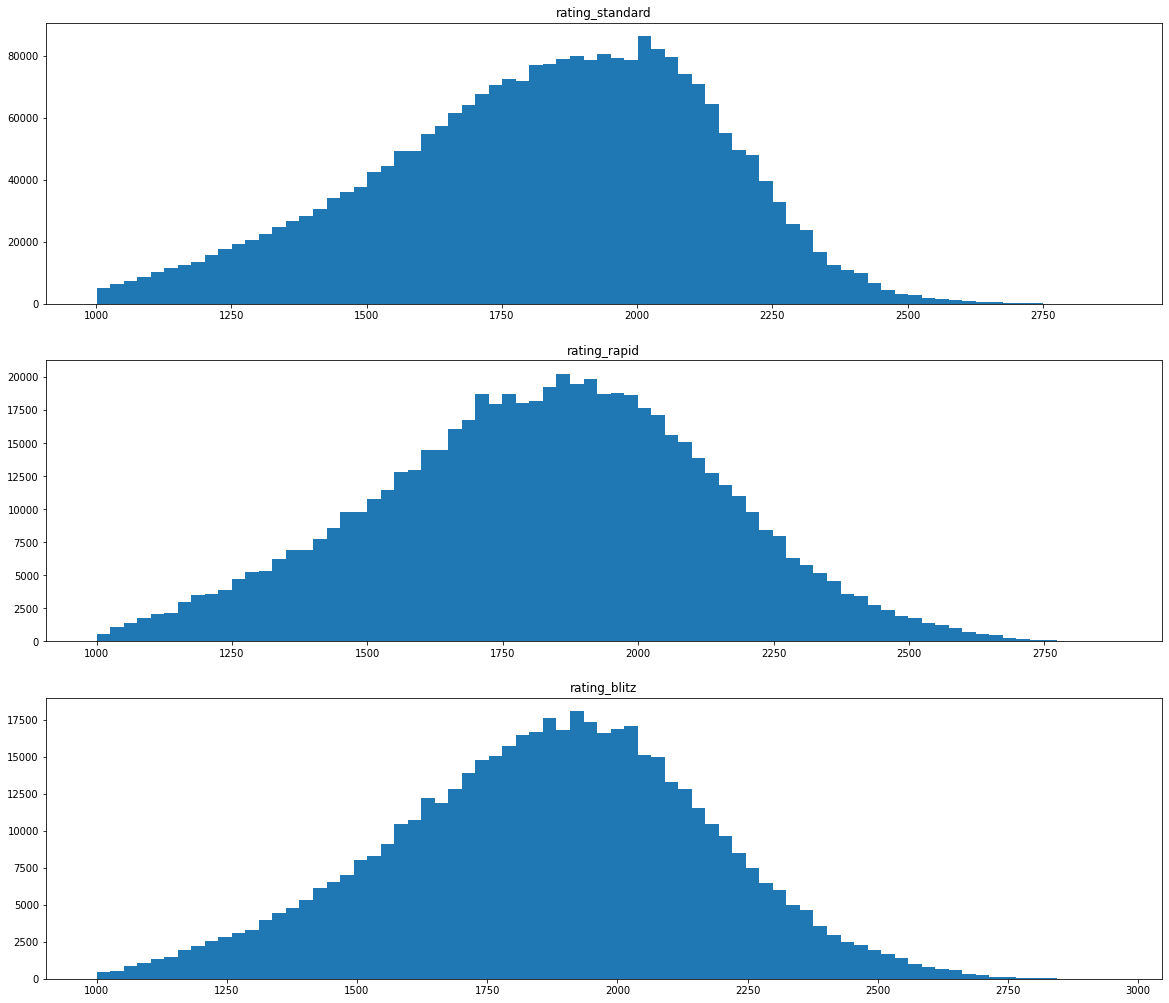

In [25]:
plt.figure(figsize=(20,30))
for i, attr in enumerate(rating_attrs):
    plt.subplot(5, 1, i+1)
    plt.title(attr)
    plt.hist(data[attr], bins=75)

**3. For supervised learning tasks, identify the target attribute(s)**

Our target attribute is already established between the rating_'standard', 'rapid', and 'blitz'... we will use these to compute predictions on time.

**4. Visualize the data** 

In [26]:
def find_player(player_name):
    return players[players['name'].str.find(player_name) != -1]

In [27]:
find_player('Iyer, Tanishq')

,fide_id,name,federation,gender,title,yob
352061,30942829,"Iyer, Tanishq",USA,M,UNTITLED,2001


In [28]:
federation = players[['federation']].value_counts(dropna=False).sort_values(ascending=False).head(10)
title = players[['title']].value_counts(dropna=False).sort_values(ascending=False).head(9)
list_title = list(title.keys())

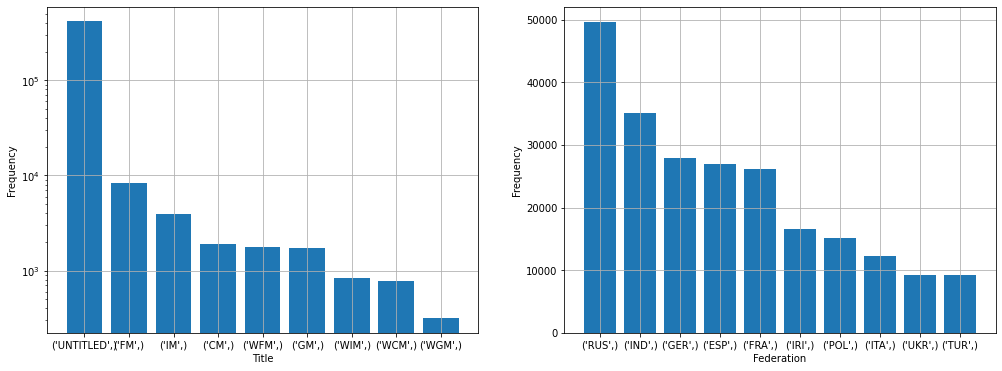

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(17, 6))
# Count of titles
axs[0].bar(range(9), title)
axs[0].set_ylabel('Frequency')
axs[0].set_yscale('log')
axs[0].set_xlabel('Title')
axs[0].grid()
axs[0].set_xticks(range(9))
axs[0].set_xticklabels(list_title)

# Count of players by federation
axs[1].bar(range(10), federation)
axs[1].set_ylabel('Frequency')
axs[1].set_xlabel('Federation')
axs[1].grid()
axs[1].set_xticks(range(10))
axs[1].set_xticklabels(federation.keys());

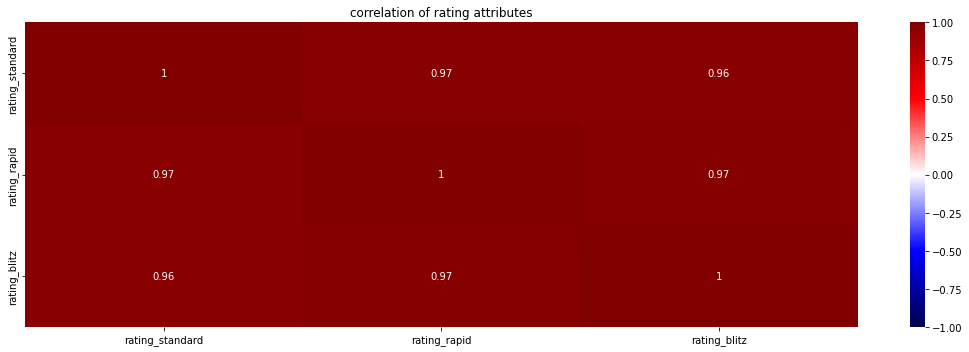

In [30]:
plt.figure(figsize=(15, 5))
plt.title('correlation of rating attributes')
sns.heatmap(data[rating_attrs].corr(), annot=True, vmin=-1, vmax=1, cmap='seismic')
plt.tight_layout()

**5. Study the correlations between attributes** 

All of the attributes (3) that are able to be coorelated with each other due to their numerical rating are very very closely coorelated. This is due to the normal distribution of each time format making it distributed extremly well.

**6. Study how you would solve the problem manually** 

In order to solve this problem manually you have would have to create an algorithm with extreme specificity that can calculate all determing factors that can predict how ones elo score might change over a period of time.

**7. Identify the promising transformations you may want to apply** 

It would be useful to join all of the ratings_ csv files together to have one cohesive set over all 7 years of data we have. Other than this there is not that much transformations in terms of what we have to do with the data. There is a ton of solid information that we will be able to work with here.

**8. Identify extra data that would be useful (go back to “Get the Data”)**

Considering we have so much data and only so much computer power doing the task at hand alone should be sufficient for our needs.

**9. Document what you have learned**

We have larned that all of our data within players.csv and ratings_*.csv coorelate and align nicely with each other. The rating types are all highly coorelated because of the normal distribution between all of the time formats. On top of all of this we have learned how to join both of our tables joined around 'fide_id' which will make our process a lot easier.

Another thing we learned is the thresholds for being associated with a certain title and how the distribution of ELO goes out amongst players at certain ranks. This will be very helpful in the long run as we try to make a model that makes accurate predictions around what rank a player is at.

Prepare the Data 
---
**1. Data cleaning: Fix/remove outliers (optional); Fill in missing values (with 0, mean, median...) or drop rows/columns**
 

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2660178 entries, 0 to 2660177
Data columns (total 11 columns):
 #   Column           Dtype  
---  ------           -----  
 0   fide_id          int64  
 1   name             object 
 2   federation       object 
 3   gender           object 
 4   title            object 
 5   yob              int64  
 6   year             int64  
 7   month            int64  
 8   rating_standard  float64
 9   rating_rapid     float64
 10  rating_blitz     float64
dtypes: float64(3), int64(4), object(4)
memory usage: 243.5+ MB


**2. Feature selection (optional): Drop attributes that provide no useful information for the task**

In [32]:
data = data.drop(columns='yob')

In [33]:
data = data.drop(columns='gender')

**3. Feature engineering, where appropriate: Discretize continuous features; Decompose feature (categorical, date/time, ...), Add promising transformations of features (log(𝑥𝑥), √𝑥𝑥, 𝑥𝑥2, ...);Aggregate features into promising new features**

**4. Feature scaling: standardize or normalize features**

Short-List Promising Models
---

**1. Train many quick and dirty models from different categories (e.g. linear, naive Bayes, SVM, Random Forests, neural net, ...) using standard parameters** 

**2. Measure and compare their performance. For each model, use 𝑁𝑁-fold cross-
validation and compute the mean and standard deviation of the performance 
measure on the 𝑁𝑁 folds.**

**3. Analyze the most significant variables for each algorithm** 

**4. Analyze the types of errors the models make. What data would a human have used to avoid these errors?** 

**5. Have a quick round of feature selection and engineering** 

**6. Have one or two more quick iterations of the five previous steps** 

**7. Short-list the top three to five most promising models, preferring models that make different types of errors** 
